|  |  |
| ----------- | ----------- |
| Author:| Benjamin Stepin |
| Affiliation:| IMOS-AODN |
| e-mail:| benjamin.stepin@utas.edu.au |
| Date of creation:| 9th May., 2024|


## Required packages

- xarray==2024.3.0
- pandas==2.2.2
- s3fs==2024.3.1
- mplcursors==0.5.3
- cartopy==0.23.0
- matplotlib==3.8.4
- ipympl==0.9.4 (this is for the #matplotlib functionality)
- h5netcdf==1.3.0

In [3]:
#this adds functionality for zooming in on data on the map.
%matplotlib widget 

import pandas as pd
import xarray as xr
import mplcursors
import s3fs
import os

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Create Functions

### load_wod_data()
This creates a function that can be called for any country or year. The keyboard inputs are year in format YYYY, and country in form string. (can handle spaces) up to 15 chars. eg "united states" not "united states of america"

### plot_wod_map()
This function plots the extracted data onto a map in order to visualise where the datasets are

In [4]:
def load_wod_data(year, specified_dataset=None, country=None):
    dfs = []

    # Path to the WOD s3 bucket (this is an open bucket)
    s3_path = f's3://noaa-wod-pds/{year}/'

    # List all files in the S3 directory
    fs = s3fs.S3FileSystem(anon=True)
    files = fs.ls(s3_path)

    # If specified_dataset is provided, check if it exists in the list of files
    if specified_dataset:
        file_name = f'wod_{specified_dataset}_{year}.nc'
        file_path = f'noaa-wod-pds/{year}/{file_name}'  # Add s3:// prefix
        if file_path not in files:
            print(f"Dataset '{specified_dataset}' not found for the year {year}.")
            return None
        files = [file_path]

    print (files)
    
    # Iterate through each file in the directory to combine all datasets for a particular year and country
    for file in files:
        with fs.open(file, 'rb') as f:
            ds = xr.open_dataset(f)

            # Define the variables of interest
            variables_of_interest = ['Access_no', 'Project', 'Institute',
                                     'originators_cruise_identifier', 'Platform',
                                     'country', 'dataset', 'lat', 'lon', 'date']
            variables = []
            
            # Iterate over each variable
            for var in variables_of_interest:
                try:
                    # Attempt to access the variable in the dataset
                    ds[var]
                    # If successful, append the variable to the list of variables
                    variables.append(var)
                except KeyError:
                    # If the variable does not exist in the dataset, continue to the next variable
                    continue

            df = ds[variables].to_dataframe()
            if 'time' in df.columns:
                df.drop(columns=['time'], inplace=True)

            # All the variables come through as byte strings so we need to decode this to readable format
            for col in df.columns:
                if isinstance(df[col][0], bytes):
                    df[col] = df[col].str.decode('utf-8')

            # Add the 'year' column with the value from the file name
            df.insert(0, 'year', int(year))

            # Filter data by country if specified
            if country:
                df = df[df['country'].str.upper() == country.upper()]

            # Append the DataFrame to the list
            dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)
    
    return combined_df


# Function to count the number of unique "Access_no" values
def count_unique_access_no(df):
    return df['Access_no'].nunique()

# Function to count the number of unique "Access_no" values
def count_unique_OCI(df):
    return df['originators_cruise_identifier'].nunique()

def plot_wod_map(df):
    plt.close()
    # Format desired_country with first letter uppercase and the rest lowercase
    formatted_country = desired_country.capitalize()

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Define the map projection
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot coastlines
    ax.coastlines()

    # Define unique dataset types
    dataset_types = df['dataset'].unique()

    # Define colors for each dataset type
    colors = plt.cm.tab10.colors[:len(dataset_types)]

    scatter_plots = []  # Collect scatter plots here

    # Plot data points for each dataset type
    for i, dataset_type in enumerate(dataset_types):
        dataset_df = df[df['dataset'] == dataset_type]
        scatter = ax.scatter(dataset_df['lon'], dataset_df['lat'],
                             transform=ccrs.PlateCarree(), s=10,
                             color=colors[i], label=dataset_type)
        scatter_plots.append(scatter)  # Add scatter plot to the list

    # Add gridlines
    ax.gridlines(draw_labels=True)

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)

    # Set bounds if you would lke to have a world map
    ax.set_ylim([-80, 80])
    ax.set_xlim([-180, 180])

    # Add title and labels
    ax.set_title(f'WOD data from {formatted_country} for {desired_year}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Enable click functionality for all scatter plots
    mplcursors.cursor(scatter_plots).connect("add", lambda sel: sel.annotation.set_text(df.iloc[sel.target.index]))

    # Show the plot
    plt.show()

## Check WOD for data products

This requires user input. There are many files in a WOD s3 directory, they can be specified in this section through user input, or if interested in all datasets this can be left blank.

These are the datasets on WOB:

| Facility Type | Abbreviation |
| ----------- | ----------- |
| XBT, BathyThermographs | xbt |
| Ocean Station Data | osd |
| Conductivity, Depth, Temp (CTD) and XCTDs (expendable CTDs) | ctd |
| profiling floats, including Argo and pre-Argo | pfl |
| Animal mounted data (seals, fish, turtles) | apb |
| Moored buoy | mrb |
| Mechanical Bathythermograph | mbt |
| undulating oceangraphic recorder | uor |
| bottle data (niskin or nansen or bucket etc) | bo |
| surface data (edited) | sur |
| ocean gliders | gld |


In [6]:
desired_year = input("Enter the desired year: ")
desired_country = input("Enter the desired country (leave blank for all countries): ").upper()
desired_dataset = input("Enter the desired dataset (eg XBT, CTD etc. or press Enter to include all datasets): ").lower()
dataframe = load_wod_data(desired_year, specified_dataset=desired_dataset, country=desired_country)
dataframe

Enter the desired year:  2022
Enter the desired country (leave blank for all countries):  australia
Enter the desired dataset (eg XBT, CTD etc. or press Enter to include all datasets):  gld


['noaa-wod-pds/2022/wod_gld_2022.nc']


,year,Access_no,Project,Institute,originators_cruise_identifier,Platform,country,dataset,lat,lon,date
0,2022,118687.0,INTEGRATED MARINE OBSERVING SYSTEM (IMOS) ** D...,AUSTRALIAN NATIONAL FACILITY FOR OCEAN GLIDERS...,SL24822-01-17,SL248 (AUV;Slocum G2 glider #248;operated by A...,AUSTRALIA,glider,-33.862949,151.309692,20220117
1,2022,118687.0,INTEGRATED MARINE OBSERVING SYSTEM (IMOS) ** D...,AUSTRALIAN NATIONAL FACILITY FOR OCEAN GLIDERS...,SL24822-01-17,SL248 (AUV;Slocum G2 glider #248;operated by A...,AUSTRALIA,glider,-33.861687,151.311188,20220117
2,2022,118687.0,INTEGRATED MARINE OBSERVING SYSTEM (IMOS) ** D...,AUSTRALIAN NATIONAL FACILITY FOR OCEAN GLIDERS...,SL24822-01-17,SL248 (AUV;Slocum G2 glider #248;operated by A...,AUSTRALIA,glider,-33.861687,151.311188,20220117
3,2022,118687.0,INTEGRATED MARINE OBSERVING SYSTEM (IMOS) ** D...,AUSTRALIAN NATIONAL FACILITY FOR OCEAN GLIDERS...,SL24822-01-17,SL248 (AUV;Slocum G2 glider #248;operated by A...,AUSTRALIA,glider,-33.860302,151.312866,20220117
4,2022,118687.0,INTEGRATED MARINE OBSERVING SYSTEM (IMOS) ** D...,AUSTRALIAN NATIONAL FACILITY FOR OCEAN GLIDERS...,SL24822-01-17,SL248 (AUV;Slocum G2 glider #248;operated by A...,AUSTRALIA,glider,-33.860302,151.312866,20220117
...,...,...,...,...,...,...,...,...,...,...,...
39733,2022,118687.0,INTEGRATED MARINE OBSERVING SYSTEM (IMOS) ** D...,AUSTRALIAN NATIONAL FACILITY FOR OCEAN GLIDERS...,SL20922-06-01,SL209 (AUV;Slocum G2 glider #209;operated by A...,AUSTRALIA,glider,-17.714754,146.320190,20220613
39734,2022,118687.0,INTEGRATED MARINE OBSERVING SYSTEM (IMOS) ** D...,AUSTRALIAN NATIONAL FACILITY FOR OCEAN GLIDERS...,SL20922-06-01,SL209 (AUV;Slocum G2 glider #209;operated by A...,AUSTRALIA,glider,-17.714176,146.320297,20220613
39735,2022,118687.0,INTEGRATED MARINE OBSERVING SYSTEM (IMOS) ** D...,AUSTRALIAN NATIONAL FACILITY FOR OCEAN GLIDERS...,SL20922-06-01,SL209 (AUV;Slocum G2 glider #209;operated by A...,AUSTRALIA,glider,-17.714176,146.320297,20220613
39736,2022,118687.0,INTEGRATED MARINE OBSERVING SYSTEM (IMOS) ** D...,AUSTRALIAN NATIONAL FACILITY FOR OCEAN GLIDERS...,SL20922-06-01,SL209 (AUV;Slocum G2 glider #209;operated by A...,AUSTRALIA,glider,-17.711926,146.320450,20220613


## Plot the data on a world map

This is an interactive map to identify particular casts from the WOD.

Number of unique Access_numbers within the WOD dataset: 1
Number of unique Cruises (eg. voyages) within the WOD dataset: 13


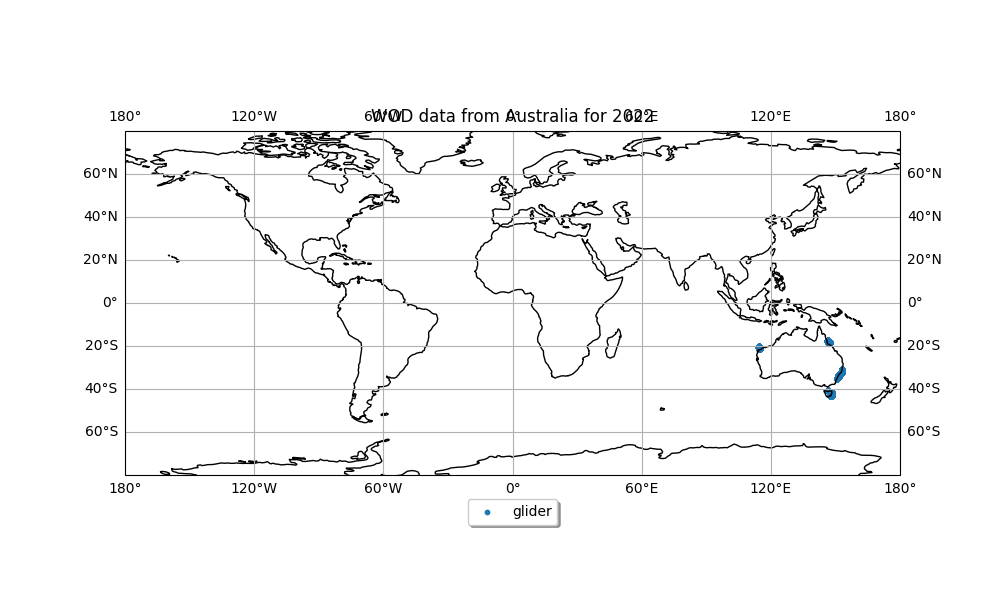

In [7]:
print (f'Number of unique Access_numbers within the WOD dataset: {count_unique_access_no(dataframe)}')
print (f'Number of unique Cruises (eg. voyages) within the WOD dataset: {count_unique_OCI(dataframe)}')
plot_wod_map(dataframe)

In [ ]:
import xarray as xr

def extract_s3_file_list(year, specified_dataset=None, country=None):
    # Path to the WOD s3 bucket (this is an open bucket)
    s3_path = f's3://noaa-wod-pds/{year}/'

    # List all files in the S3 directory
    fs = s3fs.S3FileSystem(anon=True)
    files = fs.ls(s3_path)

    # If specified_dataset is provided, filter files based on the dataset
    if specified_dataset:
        file_name = f'wod_{specified_dataset}_{year}.nc'
        file_path = f'noaa-wod-pds/{year}/{file_name}'  # Add s3:// prefix
        if file_path in files:
            files = [file_path]
        else:
            print(f"Dataset '{specified_dataset}' not found for the year {year}.")
            return None

    print (files)
    
    return files

def inspect_dimensions(files):
    fs = s3fs.S3FileSystem(anon=True)
    for file in files:
        print(f"Inspecting dimensions for file: {file}")
        with fs.open(file, 'rb') as f:
            ds = xr.open_dataset(f)
            print(ds.dims)
            ds.close()

# List of NetCDF files
files = extract_s3_file_list(year = 2019, specified_dataset = "", country = "australia")

# Call the function to inspect dimensions for each file
inspect_dimensions(files)


['noaa-wod-pds/2019/wod_apb_2019.nc', 'noaa-wod-pds/2019/wod_ctd_2019.nc', 'noaa-wod-pds/2019/wod_drb_2019.nc', 'noaa-wod-pds/2019/wod_gld_2019.nc', 'noaa-wod-pds/2019/wod_mrb_2019.nc', 'noaa-wod-pds/2019/wod_osd_2019.nc', 'noaa-wod-pds/2019/wod_pfl_2019.nc', 'noaa-wod-pds/2019/wod_xbt_2019.nc']
Inspecting dimensions for file: noaa-wod-pds/2019/wod_apb_2019.nc
FrozenMappingWarningOnValuesAccess({'casts': 62405, 'z_obs': 913524, 'Temperature_obs': 913524, 'Salinity_obs': 783340})
Inspecting dimensions for file: noaa-wod-pds/2019/wod_ctd_2019.nc
FrozenMappingWarningOnValuesAccess({'casts': 16856, 'z_obs': 2383949, 'Temperature_obs': 2383949, 'Salinity_obs': 2377627, 'Pressure_obs': 1832703, 'Oxygen_obs': 1007291, 'Nitrate_obs': 514, 'Chlorophyll_obs': 474361, 'pH_obs': 9571, 'numberofpis': 437})
Inspecting dimensions for file: noaa-wod-pds/2019/wod_drb_2019.nc
FrozenMappingWarningOnValuesAccess({'casts': 21249, 'z_obs': 3174692, 'Temperature_obs': 3174691, 'Salinity_obs': 3125906, 'Oxyge

In [ ]:
def load_wod_data(year, specified_dataset=None, country=None):
    dfs = []

    # Path to the WOD s3 bucket (this is an open bucket)
    s3_path = f's3://noaa-wod-pds/{year}/'

    # List all files in the S3 directory
    fs = s3fs.S3FileSystem(anon=True)
    files = fs.ls(s3_path)

    # If specified_dataset is provided, check if it exists in the list of files
    if specified_dataset:
        file_name = f'wod_{specified_dataset}_{year}.nc'
        file_path = f'noaa-wod-pds/{year}/{file_name}'  # Add s3:// prefix
        if file_path not in files:
            print(f"Dataset '{specified_dataset}' not found for the year {year}.")
            return None
        files = [file_path]

    print(files)

    def process_file(file):
        with fs.open(file, 'rb') as f:
            ds = xr.open_dataset(f, use_cftime=False)
            variables_of_interest = ['Access_no', 'Project', 'Institute',
                                     'originators_cruise_identifier', 'Platform',
                                     'country', 'dataset', 'lat', 'lon', 'date']
            data = {}
            for var in variables_of_interest:
                try:
                    data[var] = ds[var].values.astype(str)
                except KeyError:
                    print(f"Variable '{var}' not found in file: {file}. Skipping...")
            df = pd.DataFrame(data)
            return df

    # Iterate through each file in the directory to combine all datasets for a particular year and country
    for file in files:
        df = process_file(file)
        if df is not None:
            if 'time' in df.columns:
                df.drop(columns=['time'], inplace=True)

            # All the variables come through as byte strings so we need to decode this to readable format
            for col in df.columns:
                if isinstance(df[col][0], bytes):
                    df[col] = df[col].str.decode('utf-8')

            # Add the 'year' column with the value from the file name
            df.insert(0, 'year', int(year))

            # Filter data by country if specified
            if country:
                df = df[df['country'].str.upper() == country.upper()]

            # Append the DataFrame to the list
            dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df


# Function to count the number of unique "Access_no" values
def count_unique_access_no(df):
    return df['Access_no'].nunique()

# Function to count the number of unique "Access_no" values
def count_unique_OCI(df):
    return df['originators_cruise_identifier'].nunique()

def plot_wod_map(df):
    # Format desired_country with first letter uppercase and the rest lowercase
    formatted_country = desired_country.capitalize()

    # Create a new figure
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    # Define unique dataset types
    dataset_types = df['dataset'].unique()
    colors = plt.cm.tab10.colors[:len(dataset_types)]

    scatter_plots = []  # Collect scatter plots here

    # Plot data points for each dataset type
    for i, dataset_type in enumerate(dataset_types):
        dataset_df = df[df['dataset'] == dataset_type]
        print(dataset_df['lon'])
        scatter = ax.scatter(dataset_df['lon'], dataset_df['lat'],
                             transform=ccrs.PlateCarree(), s=10,
                             color=colors[i], label=dataset_type)
        scatter_plots.append(scatter)  # Add scatter plot to the list

    # Add gridlines
    ax.gridlines(draw_labels=True)

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)

    # Set bounds if you would lke to have a world map
    ax.set_ylim([-80, 80])
    ax.set_xlim([-180, 180])

    # Add title and labels
    ax.set_title(f'WOD data from {formatted_country} for {desired_year}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Enable click functionality for all scatter plots
    mplcursors.cursor(scatter_plots).connect("add", lambda sel: sel.annotation.set_text(df.iloc[sel.target.index]))

    # Show the plot
    plt.show()